In [818]:
%matplotlib inline
import bz2
import json
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import glob
import fastjet
import awkward as ak
import vector
import math
from operator import mul

In [2]:
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)# What is this?

## Datasets

CLIC detector model, Full Geant4 simulation: https://hepsim.jlab.org/taginfo.php?id=rfull201.

- `/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/`

In [ ]:
#This is is all data. 3600 files . 
#When something works then loop over that data

# Plot one event

(-2000.0, 2000.0)

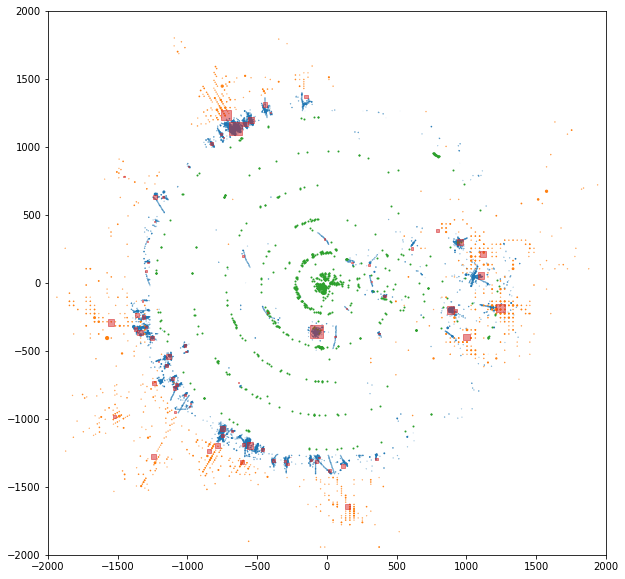

In [3]:
data = json.load(bz2.BZ2File("../testdata/pythia6_ttbar_0001_pandora_0.json.bz2", "r"))

iev = 0 #ith event
df_gen = pandas.DataFrame(data[iev]["genparticles"]) #Truth information electrons
#Data clic simulation. 
#we need particle flow date. Generated data .
# The data is 

# gen particles move to hits and ecal hits and so fourth
df_hit = pandas.DataFrame(data[iev]["track_hits"])#tracks compose of "hits"
df_cl = pandas.DataFrame(data[iev]["clusters"])
df_tr = pandas.DataFrame(data[iev]["tracks"])
df_ecal = pandas.DataFrame(data[iev]["ecal_hits"])
df_hcal = pandas.DataFrame(data[iev]["hcal_hits"])

df_pfs = pandas.DataFrame(data[iev]["pfs"])
#PFS is the data used.
    
plt.figure(figsize=(10,10))
plt.scatter(df_ecal["x"], df_ecal["y"], s=5*df_ecal["energy"]);#dark blue ecal deposits
plt.scatter(df_hcal["x"], df_hcal["y"], s=5*df_hcal["energy"]);#orange hcal deposits
#Charged and neutral hadrons may initiate a hadronic shower in the ECAL as well,
#which is subsequently fully absorbed in the hadron calorimeter (HCAL).
plt.scatter(df_hit["x"], df_hit["y"], s=1);#green tracker hits?
plt.scatter(df_cl["x"], df_cl["y"], s=5*df_cl["energy"], alpha=0.5, marker="s"); # red squares clusters energy depos? s is "markersize**2" So the squares

plt.xlim(-2000,2000)
plt.ylim(-2000,2000)

In [4]:
df_pfs 
#What are types. So the cluster_idx says to which cluster a particle 

,charge,cluster_idx,energy,px,py,pz,track_idx,type
0,0.0,0,0.503544,-0.353482,-0.320373,0.161146,-1,22
1,1.0,1,0.471189,-0.259074,-0.274876,0.244668,0,211
2,1.0,2,0.725461,-0.146924,0.523242,-0.459831,41,211
3,0.0,3,0.277013,-0.275606,-0.027047,0.006757,-1,22
4,0.0,4,0.691343,-0.184112,-0.067905,-0.662908,-1,2112
...,...,...,...,...,...,...,...,...
79,0.0,79,5.157015,-2.761861,-1.313529,4.152297,-1,22
80,-1.0,80,0.926568,-0.441712,0.655114,-0.463426,2,-211
81,-1.0,81,3.106948,1.182773,-0.018109,-2.869558,8,-211
82,0.0,82,0.179223,-0.122948,-0.113782,0.063706,-1,22


In [8]:
#is there a description of datasest event structure. Meaning what is cluster what is track hits etc? Still a question
#one event described
print(len(data[0]['clusters']))
print(len(data[0]['track_hits']))
print(len(data[0]["tracks"]))
print(len(data[0]["ecal_hits"]))



#What are clusters again?
# What is gp, gp_contributions?



34
288
20
3028


In [9]:
#An old detector note describing how to compute track parameters
#http://flc.desy.de/lcnotes/notes/localfsExplorer_read?currentPath=/afs/desy.de/group/flc/lcnotes/LC-DET-2006-004.pdf 
a = 3*10**-4
b = 5 #B-field in tesla



def track_pt(omega):
    return a*np.abs(b/omega)

In [10]:
#Create the genparticle -> track/cluster -> particle flow event graph
#Graph means. 
def event_to_graph(df_gen, df_cl, df_tr, df_pfs):
    g = nx.DiGraph()
    
    #Add genparticles
    for igen in range(len(df_gen)):
        g.add_node("gen{}".format(igen), typ=int(df_gen.iloc[igen]["pdgid"]), e=df_gen.iloc[igen]["energy"])

    #Add links to parents
    for igen in range(len(df_gen)):
        
        #Add links to parents
        idx_parent0 = int(df_gen.iloc[igen]["idx_parent0"])
        if idx_parent0 != -1:
            g.add_edge("gen{}".format(idx_parent0), "gen{}".format(igen), w=0)
            
        idx_parent1 = int(df_gen.iloc[igen]["idx_parent1"])
        if idx_parent1 != -1:
            g.add_edge("gen{}".format(idx_parent1), "gen{}".format(igen), w=0)
            
    #Add calorimeter clusters
    for icl in range(len(df_cl)):
        g.add_node(
            "clu{}".format(icl),
            typ=df_cl.iloc[icl]["type"],
            e=df_cl.iloc[icl]["energy"]
        )
        
        #Add links from genparticles to cluster
        #The weight is the energy contribution from the genparticle
        for gp, gp_w in df_cl.iloc[icl]["gp_contributions"].items():
            gp = int(gp)
            if gp_w/df_cl.iloc[icl]["energy"]>0.2:
                g.add_edge("gen{}".format(gp), "clu{}".format(icl), w=gp_w)

    #Add tracks
    for itr in range(len(df_tr)):
        g.add_node("tra{}".format(itr), typ=0, e=df_tr.iloc[itr]["pt"])
        
        #Add links from genparticles to track.
        #The weight is the number of hits in the track that came from this genparticle
        for gp, gp_w in df_tr.iloc[itr]["gp_contributions"].items():
            gp = int(gp)
            if gp_w/df_tr.iloc[itr]["nhits"]>0.2:
                g.add_edge("gen{}".format(gp), "tra{}".format(itr), w=gp_w)

    #Add PF objects
    for ipf in range(len(df_pfs)):
        g.add_node(
            "pfo{}".format(ipf),
            typ=int(df_pfs.iloc[ipf]["type"]),
            e=df_pfs.iloc[ipf]["energy"]
        )
        
        #Add link from cluster to PF object if available
        cl_idx = int(df_pfs.iloc[ipf]["cluster_idx"])
        if cl_idx!=-1:
            g.add_edge("clu{}".format(cl_idx), "pfo{}".format(ipf), w=0)

        #Add link from track to PF object if available
        tr_idx = int(df_pfs.iloc[ipf]["track_idx"])
        if tr_idx!=-1:
            g.add_edge("tra{}".format(tr_idx), "pfo{}".format(ipf), w=0)
    return g
#Can ignore this code basically. Reconstructing graph cahin

In [11]:
#Given the decay graph, estiamte the energy in each PF object that came from the generator-level tau
def get_tau_fractions(df_tau, df_pfs, g):
    
    tau_genparticles = [
        "gen{}".format(x) for x in df_tau.index
    ]
    
    energy_tau_tr = np.zeros_like(df_pfs["energy"])
    energy_tau_cl = np.zeros_like(df_pfs["energy"])
    
    for genp in tau_genparticles:
        
        #Get all the nodes reachable from this gen tau
        ng = nx.descendants(g, genp)
        
        #Find the particle flow objects downstream from the gen tau
        pfs = [node for node in ng if node.startswith("pfo")]
        
        #Loop over all the particle flow objects
        for pfpart in pfs:
            ipf = int(pfpart[3:])
            
            e_tr = 0.0
            e_cl = 0.0
            for pred in list(g.predecessors(pfpart)):
                
                #if this PF object came from a track, get the energy from the parent genparticle
                if pred.startswith('tra'):
                    track_preds = list(g.predecessors(pred))
                    for this_tr_pred in track_preds:
                        e_tr += g.nodes[this_tr_pred]["e"]
                        
                #if this PF object came from a cluster, get the energy from the edge
                elif pred.startswith('clu'):
                    cl_preds = list(g.predecessors(pred))
                    for this_cl_pred in cl_preds:
                        e_cl += g.edges[(this_cl_pred, pred)]["w"]
            
            energy_tau_tr[ipf] = e_tr
            energy_tau_cl[ipf] = e_cl
            
#             print("  {} {} E_pf={:.2f} E_tau_tr={:.2f} E_tau_cl={:.2f}".format(
#                 pfpart, g.nodes[pfpart]["typ"], g.nodes[pfpart]["e"], e_tr, e_cl)
#             )
    df_pf_taufracs = pandas.DataFrame()
    df_pf_taufracs["energy_tau_tr"] = energy_tau_tr
    df_pf_taufracs["energy_tau_cl"] = energy_tau_cl
    return df_pf_taufracs

#I dont need. Each PF canditade and how much comes from TAU.

In [12]:
def compute_track_properties(df_tr):
    df_tr["pt"] = track_pt(df_tr["omega"])
    df_tr["px"] = np.cos(df_tr["phi"])*df_tr["pt"]
    df_tr["py"] = np.sin(df_tr["phi"])*df_tr["pt"]
    df_tr["pz"] = df_tr["tan_lambda"]*df_tr["pt"]
    
#Properties of the tracks #read track properties if ypu want to use.

In [13]:
def computeJet(pfs_this_jet):
    p4sum = {'px':0, 'py':0, 'pz':0, 'energy':0 }
    for key in p4sum:
        for e in pfs_this_jet[key]:
            p4sum[key]+=e
    return vector.obj(x=p4sum['px'],y=p4sum['py'],z=p4sum['pz'],E=p4sum['energy'])

In [14]:
def process_one_event(data, iev):
    
    #Get the dataframes corresponding to this event
    df_gen = pandas.DataFrame(data[iev]["genparticles"])
    df_hit = pandas.DataFrame(data[iev]["track_hits"])
    df_cl = pandas.DataFrame(data[iev]["clusters"])
    df_tr = pandas.DataFrame(data[iev]["tracks"])
    df_ecal = pandas.DataFrame(data[iev]["ecal_hits"])
    df_hcal = pandas.DataFrame(data[iev]["hcal_hits"])
    df_pfs = pandas.DataFrame(data[iev]["pfs"])
    compute_track_properties(df_tr)#Might be useful

    #Get the generator taus with status==2
    #PDG= number assigned to generator particles
    #Status=2 mean this is the last tau in the decay chain. 
    df_tau = df_gen[(df_gen["pdgid"].abs()==15) & (df_gen["status"]==2)]
    
    #cluster the PF particles to jets, reorder by pt descending.
    cluster = fastjet.ClusterSequence(ak.Array({
        "px": df_pfs["px"],
        "py": df_pfs["py"],
        "pz": df_pfs["pz"],
        "E": df_pfs["energy"],
    }), jetdef)
    jets_constituents = cluster.constituent_index(min_pt=5)[::-1]
    #Usually anti k_t jets. 
    
    #Get the tau contributions in each PF object
    graph = event_to_graph(df_gen, df_cl, df_tr, df_pfs)
    df_pfs_taufrac = get_tau_fractions(df_gen, df_pfs, graph)
    
    #Now get the list of PF objects in each jet
    pfs_by_jet = []
    jets = []
    for jet_constituents in jets_constituents:
        
        #Get the PF objects corresponding to this jet
        pfs_jet = df_pfs.iloc[jet_constituents]
        pfs_jet_additional = df_pfs_taufrac.iloc[jet_constituents]
        pfs_this_jet = pandas.concat([pfs_jet, pfs_jet_additional], axis=1)
        pfs_by_jet.append(pfs_this_jet)
        jet = computeJet(pfs_this_jet)
        jets.append(jet)

    #return the gen taus, the computed jet, the list of PF candidates in each jet, cluster, tracks and genparticles
    return df_tau, jets, pfs_by_jet, df_cl, df_tr, df_gen
#pfs_by_jet

In [438]:
def filterPFS(pfs, df_cl, df_tr, df_gen): #quality criteria for pfs: https://cmssdt.cern.ch/lxr/source/RecoTauTag/RecoTau/python/PFRecoTauQualityCuts_cfi.py
    goodPFS =[]
    for ipf, pf in enumerate(pfs.iterrows()):
        pftype = abs(int(pf[1]['type']))
        if pftype == 211 or pftype == 11: #charged pion / electron 
            trackidx = int(pf[1]['track_idx'])
            if trackidx <0:
                print('faulty pf')
                continue
            if df_tr.iloc[trackidx]['pt']<0.5: continue # track pt cut
            if df_tr.iloc[trackidx]['z0']>0.4 : continue #dz cut, are these wrt primary vertex or detector center?
            if math.sqrt(max(0,df_tr.iloc[trackidx]['d0']**2-df_tr.iloc[trackidx]['z0']**2)) >0.1 : continue #dxy cut, are these wrt primary vertex or detector center?
            if df_tr.iloc[trackidx]['nhits']<5 : continue # nhits? do we need a chi2 cut ?
        elif pftype == 22 or pftype == 2112: #photon / pi0 / neutral hadron
            clusteridx = int(pf[1]['cluster_idx'])
            if clusteridx <0:
                print('faulty pf')
                continue
            tempPF = vector.obj(x=pf[1]['px'],y=pf[1]['py'],z=pf[1]['pz'],E=pf[1]['energy'])
            if tempPF.pt < 1 : continue
            if tempPF.pt < 30 and pftype == 2112 : continue
        goodPFS.append(pf)
    return goodPFS
# do not need to undersrnd
def cleanJets(df_tau, jets, pfs_by_jet, df_cl, df_tr,df_gen, cleanPFS=True, recomputeJet=False, matchingCone=0.3, invertTau=False):
    matched_jets = []
    cleaned_pfs_by_matchedjet = []
    matched_tau = []
    for njet, jet in enumerate(jets):
        cleaned_pfs = pfs_by_jet[njet]
        if cleanPFS: cleaned_pfs = filterPFS(cleaned_pfs,df_cl, df_tr, df_gen)
        cleanedJet = jet
        if recomputeJet: cleanedJet = computeJet(cleaned_pfs)
        matchedTau = None
        matchedTau_index = -1
        #Units in GeV
        for itau, tau in enumerate(df_tau.iterrows()):
            #print(tau[1])
            tempTau = vector.obj(x=tau[1]['px'],y=tau[1]['py'],z=tau[1]['pz'],E=tau[1]['energy'])
            #print(tempTau)
            #if tau is not hadronic then skip it-function needed iterate over df_gen
            if matchedTau is None:
                if tempTau.deltaR(cleanedJet)<matchingCone :
                    matchedTau=tempTau
                    matchedTau_index=itau 
        
            elif tempTau.deltaR(cleanedJet) < matchedTau.deltaR(cleanedJet) :
                
                matchedTau=tempTau
                matchedTau_index=itau
        if invertTau and matchedTau is None:
            matched_jets.append(cleanedJet)
            cleaned_pfs_by_matchedjet.append(cleaned_pfs)
        elif matchedTau is not None:
            matched_tau.append(df_tau.iloc[matchedTau_index])
            matched_jets.append(cleanedJet)
            cleaned_pfs_by_matchedjet.append(cleaned_pfs)
    return matched_tau, matched_jets, cleaned_pfs_by_matchedjet
#

# Process one event

In [945]:
data = json.load(bz2.BZ2File("../testdata/pythia6_ttbar_0001_pandora_4.json.bz2", "r"))
data = json.load(bz2.BZ2File("/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/pythia6_ttbar_0115_pandora_10.json.bz2", "r"))
ret = process_one_event(data, 3)
ret = cleanJets(ret[0], ret[1], ret[2], ret[3], ret[4], ret[5])
print(ret[0], ret[1], ret[2])
#Tau properties are printed
#name 22 is jets
#and below that PF canditaes. 
#ERROR event 4-pandora0?
#Interesting event pandora2 event 8
#pandora 4 event 3 even better.

[] [] []


In [602]:
def get_e_and_y(event_pfs):
    #Funtion to get pf candidates that are photons or electrons
    e_and_y = []
    for pf in event_pfs:
        pf_type=abs(pf[1].type)
        if pf_type == 22 or pf_type == 11: #photon(22) or electron(11)
            #print(pf_type)
            #print(pf[1])
            e_and_y.append(pf[1])
            
    return e_and_y

def get_pions(event_pfs):
        #Funtion to get pf candidates that are pions
    pions = []
    for pf in event_pfs:
        pf_type=abs(pf[1].type)
        #print(pf_type)
        if pf_type == 111 or pf_type == 211: #pi^0(22) or pi^+(11)
            pions.append(pf[1])
    return pions  
def get_electrons(event_pfs):
    #Funtion to get pf candidates that are photons or electrons
    electrons = []
    for pf in event_pfs:
        pf_type=abs(pf[1].type)
        if pf_type == 11: #photon(22) or electron(11)
            #print(pf_type)
            #print(pf[1])
            electrons.append(pf[1])
    return electrons

def get_pf_mass(pf_obj):
    obj_lv=getPF_lv(pf_obj)#object lorentz vector
    mass=obj_lv.m #invariant mass of object
    return mass  

def get_invm(pf_obj):# just hands on version of previous mass function
    inv_m=np.sqrt((pf_obj.energy**2)-(pf_obj.px**2)-(pf_obj.py**2)-(pf_obj.pz**2))
    return inv_m

def deltaR(vec1,vec2):#hands on version of deltaR function
    deltaR=np.sqrt((vec1.phi-vec2.phi)**2+(vec1.eta-vec2.eta)**2)
    return deltaR

def getPF_lv(pf_obj):
    #Function for getting lorentz momentum vector from PF candidates
    tempPF = vector.obj(x=pf_obj['px'],y=pf_obj['py'],z=pf_obj['pz'],E=pf_obj['energy'])
    return(tempPF)

def get_all_PF_lv(pf_objects):
    #Function that converts and returns pf objects as lorentz vectors
    lvs=[]
    for obj in pf_objects:
        lvs.append(getPF_lv(obj))
    return lvs
def sort_by_pt(pf_objects):
    #Function that sorts pf objects by pt in descending order 
    #returns both lvs and pfs in same order
    PF_lv_objects=get_all_PF_lv(pf_objects)
    pts=[obj.pt for obj in PF_lv_objects]
    sorted_indx=sorted(range(len(pts)), reverse=True, key=lambda k: pts[k])#https://stackoverflow.com/questions/7851077/how-to-return-index-of-a-sorted-list
    sorted_lvs=[]
    sorted_pfs=[]
    for  indx in sorted_indx:
        sorted_lvs.append(PF_lv_objects[indx])
        sorted_pfs.append(pf_objects[indx])
        
    return sorted_lvs,sorted_pfs

def calc_strips_masses(all_strips):
    masses=[]
    for event_strips in all_strips:
        #print(event_strips)
        if len(event_strips) > 1:
            for strip in event_strips:
                strip_mass=0
                strip_p4=vector.obj(x=0,y=0,z=0,E=0)
                for strip_comp in strip['lvs']:
                    #print(strip_comp.mass)
                    strip_p4+=strip_comp
                    #strip_mass += strip_comp.mass
                    #print(strip_mass)
                masses.append(strip_p4.mass)
                #print(masses)
                
                
        else:
            #print(event_strips[0]['lvs'])
            #print(event_strips[0]['lvs'][0].mass)
            masses.append(event_strips[0]['lvs'][0].mass)
    return masses

#event_pfs=ret[2][0]

def cal_strips_event(event_pfs):
    #Function returns strips as pf objects with thei complimentary lorentz vectros
    e_and_y=get_e_and_y(event_pfs)
    sorted_lvs,sorted_pfs=sort_by_pt(e_and_y)
    
    strips=[]
    while len(sorted_lvs) != 0:
        strip={ "lvs" : [] , "pfs" : []}
        strip['lvs'].append(sorted_lvs[0])
        strip['pfs'].append(sorted_pfs[0])
        seed_loc={ "eta" : sorted_lvs[0].eta, "phi" : sorted_lvs[0].phi}
        eta_bounds,phi_bounds=calc_window(seed_loc)
        del sorted_lvs[0],sorted_pfs[0] # remove from list so it will be easier to loop
    
        if len(sorted_lvs) ==1 :
            strip['lvs'].append(sorted_lvs[0])
            strip['pfs'].append(sorted_pfs[0])
        for i,lv in enumerate(sorted_lvs):
            #print(i)
            #print(lv)
            if check_if_in_window(lv,eta_bounds,phi_bounds) == True:
                #print('if True')
                #add to strip
                strip['lvs'].append(sorted_lvs[i])
                strip['pfs'].append(sorted_pfs[i])
                del sorted_lvs[0],sorted_pfs[0]
                #test_strip=strip
                strip_loc= calc_strip_loc(strip)
                #print(strip_loc)
                eta_bounds,phi_bounds=calc_window(strip_loc)
                #print(eta_bounds, phi_bounds)
            #else:
                #print('not in bounds')
        strips.append(strip)
    
    return strips

def calc_strip_loc(strip_lv_objects):
    strip_objects_eta=[obj.eta for obj in strip_lv_objects['lvs']]
    strip_objects_phi=[obj.phi for obj in strip_lv_objects['lvs']]
    #print(strip_objects_eta)
    #print(strip_objects_phi)
    #pf_object_eta=pf_object.eta
    #pf_object_phi=pf_object.phi
    strip_objects_pt= [obj.pt for obj in strip_lv_objects['lvs']]
    #pf_object_pt=pf_object.pt
    #pt_strip=pf_object_pt
    eta_mult=[*map(mul,strip_objects_pt,strip_objects_eta)]
    phi_mult=[*map(mul,strip_objects_pt,strip_objects_phi)]
    eta_strip=(1/sum(strip_objects_pt))*sum(eta_mult)
    phi_strip=(1/sum(strip_objects_pt))*sum(phi_mult)
    strip_loc={ "eta" : eta_strip, "phi" : phi_strip}
    return strip_loc
        

def calc_window(seed_loc):
    #Function to calculate window for strip origin. Size (eta X phi)= (0.05 X 0.20)
    eta_bounds= [seed_loc['eta']-0.025, seed_loc['eta']+0.025]
    phi_bounds= [seed_loc['phi']-0.1, seed_loc['phi']+0.1]
    return eta_bounds,phi_bounds
def check_if_in_window(pf_object,eta_bounds,phi_bounds):
    #Function to check whether ovject is in strip origin window
    pf_object_eta=pf_object.eta
    pf_object_phi=pf_object.phi
    #print(pf_object_eta)
    #print(pf_object_phi)
    #print(eta_bounds[0],eta_bounds[1])
    if eta_bounds[0] < pf_object_eta < eta_bounds[1] and phi_bounds[0] < pf_object_phi < phi_bounds[1]:
        return True
    else:
        return False

In [861]:
event_pfs=ret[2][0]

cal_strips_event(event_pfs)

[{'lvs': [vector.obj(px=-4.230795383453369, py=-0.6769526600837708, pz=2.395169496536255, E=4.9086384773254395)],
  'pfs': [charge            0.000000
   cluster_idx      14.000000
   energy            4.908638
   px               -4.230795
   py               -0.676953
   pz                2.395169
   track_idx        -1.000000
   type             22.000000
   energy_tau_tr     0.000000
   energy_tau_cl     5.093612
   Name: 14, dtype: float64]}]

In [730]:
from operator import mul
list1=[1,2,3]
list2=[1,2,3]
[*map(mul,list1,list2)]

[1, 4, 9]

[-0.7431784667916799, 3.048721790997009]

In [817]:
seed_loc={'eta' : strips[0]['lvs'][0].eta, "phi" : strips[0]['lvs'][0].phi}
print(f'window: {calc_window(seed_loc)}')
#print(f' loc {strip['lvs'][1].eta,  strip['lvs'][1].phi} ')
seed_loc2={'eta' : strips[0]['lvs'][1].eta, "phi" : strips[0]['lvs'][1].phi}
print(seed_loc2)

window: ([-0.6708204516183678, -0.6208204516183677], [2.6642361980112637, 2.864236198011264])
{'eta': -0.6233909230719732, 'phi': 2.857109777646021}


In [753]:
#Kontroll
obj1=test_strip['lvs'][0]
obj2=test_strip['lvs'][1]
print(f'obj 1 eta,phi and pt: {obj1.eta, obj1.phi, obj1.pt}')
print(f'obj 2 eta,phi and pt: {obj2.eta, obj2.phi, obj2.pt}')
#õige

obj 1 eta,phi and pt: (-0.6458204516183678, 2.7642361980112637, 16.570851805546422)
obj 2 eta,phi and pt: (-0.6233909230719732, 2.857109777646021, 7.377016606165354)


In [749]:
calc_strip_loc(test_strip)

[-0.6458204516183678, -0.6233909230719732]
[2.7642361980112637, 2.857109777646021]


(-0.6389111517295187, 2.792845422325548)

In [699]:
strip['lvs']

[vector.obj(px=-15.404958724975586, py=6.1057658195495605, pz=-11.46138858795166, E=20.14836311340332),
 vector.obj(px=-7.080511569976807, py=2.070441961288452, pz=-4.9024658203125, E=8.857457160949707),
 vector.obj(px=-1.4872286319732666, py=0.13851867616176605, pz=-1.2151029109954834, E=1.9254900217056274)]

In [259]:
#DeltaR test
examp1=ret[2][0][0][1]
examp2=ret[2][0][1][1]
examp2.type
vec1=getPF_lv(examp1)
vec2=getPF_lv(examp2)
#Dr (solid angle) leiad kahe vecktori lv vectori järgi
print(vec1.deltaR(vec2))
#pikalt on $\Delta R = \sqrt{\Delta\phi^2 + \Delta\eta^2}$
def deltaR(vec1,vec2):
    deltaR=np.sqrt((vec1.phi-vec2.phi)**2+(vec1.eta-vec2.eta)**2)
    return deltaR
print(deltaR(vec1,vec2))

0.11360930532302599
0.11360930532302599


# Strips
To reconstruct the full energy of the neutral pions, the electron and
photon candidates falling within a certain region of ∆η×∆φ are clustered together, with the
resulting object referred to as a “strip”. 

The initial position of the strip in the η − φ plane is set
according to the η and φ of the seed e or γ.

In [ ]:
#Are electrons in same strip

In [559]:
print(f'eta_bounds: {eta_bounds}, phi_bounds: {phi_bounds}')
print(f'photon eta:{photon.eta}, electron phi: {photon.phi}')
print(f'electron eta:{electron.eta}, electron phi: {electron.phi}')
print(f'electron2 eta:{electron2.eta}, electron2 phi: {electron2.phi}')

eta_bounds: [-0.6708204516183678, -0.6208204516183677], phi_bounds: [2.6642361980112637, 2.864236198011264]
photon eta:-0.6458204516183678, electron phi: 2.7642361980112637
electron eta:-0.6233909230719732, electron phi: 2.857109777646021
electron2 eta:-0.7431784667916799, electron2 phi: 3.048721790997009


In [549]:
eta= -1
phi=1
eta_bounds= [eta-0.025, eta+0.025]
phi_bounds= [phi-0.1, phi+0.1]
length=abs(eta_bounds[0]-eta_bounds[1])
width=abs(phi_bounds[0]-phi_bounds[1])
print(length,width)
print(eta_bounds,phi_bounds)


0.04999999999999993 0.20000000000000007
[-1.025, -0.975] [0.9, 1.1]


In [ ]:
event 3 one photon and pion. 2 decay modes can be bulit. I have one strip
event 1 is boring one electron
If empty - cleanJETS
COne important

In [ ]:
#phi azimuthal angle(transverse plane) theta polar angle(parallel to z). 
#22-photon
#11-electron
#211-pion
#111- neutral pion

In [ ]:
#neutron code mean neutron. because you can not be sure.
#we have a tau and in the end i see charged pions and photons. 
# For mor events try to see if i can reimplement HPS. First try to do strips and plot out. 
#And try to understand whats going on. Negative masses would be bad :D. Maybe need to poke 
#filterPFS and clean jets but above them it I do not need. Strips with lists below jets. 
# ONE IMPORTANT THING: python functions for 4 vector moduls. DeltaR and shit like that.

# Process all the data

In [ ]:
/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/pythia6_ttbar_0115_pandora_10.json.bz2

In [946]:
for fn in glob.glob("/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/*.json.bz2"):
    
    #Load the data file consisting of multiple events
    data = json.load(bz2.BZ2File(fn, "r"))
    
    #Loop over the events in the data file
    for iev in range(len(data)):
        #print(iev)
        process_one_event(data, iev)

KeyboardInterrupt: 

In [ ]:
pion_masses=[]
electron_masses=[]
all_strips=[]
errors=0
event_count=0
for nf,fn in enumerate(glob.glob("/scratch-persistent/joosep/ml-tau-reco/clic/gev380ee_pythia6_ttbar_rfull201/*.json.bz2")):
    if not nf % 100: print("fail: "+str(nf))
    #event_count+=1
    #if nf > 100:
    #    continue
    #Load the data file consisting of multiple events
    data = json.load(bz2.BZ2File(fn, "r"))
    
    #Loop over the events in the data file
    for iev in range(len(data)):
        #print(iev)
        event_count+=1
        ret=process_one_event(data, iev)
        try:
            ret = cleanJets(ret[0], ret[1], ret[2], ret[3], ret[4], ret[5])
        except Exception:
            errors +=1
            continue
        #print(iev)
        #print(ret)
        if len(ret[2]):#if list contains something do it:
            #print("Yeah contained something")
            event_pfs=ret[2][0]
            pions=get_pions(event_pfs)
            electrons=get_electrons(event_pfs)
            for el in electrons:
                electron_masses.append(get_pf_mass(el)*10**3)# Adding pion masses
            for pion in pions:
                pion_masses.append(get_pf_mass(pion)*10**3)# Adding pion masses
                
            strips=cal_strips_event(event_pfs)
            if len(strips)!=0: #some events contain only pions. Have to fix it right no just a patch with a if clause
                all_strips.append(strips)
            
            
                
            
            #temptau error exception
        else: #if empty continue
            continue
            
        #print(f'errors:{errors} ')

fail: 0
fail: 100
fail: 200
fail: 300
fail: 400


In [954]:
strip_masses=calc_strips_masses(all_strips)

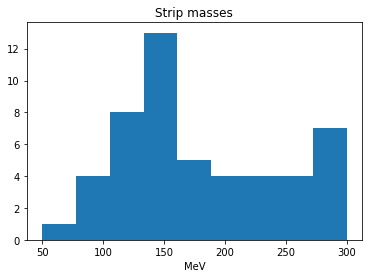

In [960]:
#strip masses
from matplotlib import pyplot as plt
bins=np.linspace(50,300,10)
strip_masses_mev=[strip_mass*10**3 for strip_mass in strip_masses]
plt.hist(strip_masses_mev,bins=bins)
plt.xlabel('MeV')
plt.title('Strip masses')
plt.show()
#1.5 MeV low mass combined electron and brem and resolution error. Still a good approx?
#ask Joosep why?

In [ ]:
#bigger mev = n-pions 150 MeV
#plot eta and phi
#Do it on all events etas and phis.

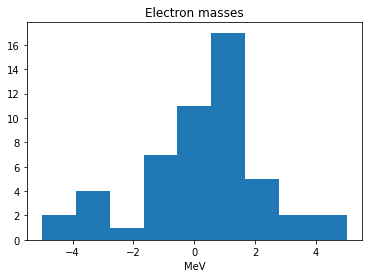

In [962]:
#electron masses
from matplotlib import pyplot as plt
bins=np.linspace(-5,5,10)
plt.hist(electron_masses,bins=bins)
plt.xlabel('MeV')
plt.title('Electron masses')
plt.show()
#1.5 MeV low mass combined electron and brem and resolution error. Still a good approx?
#ask Joosep why?

In [ ]:
#pion masses
from matplotlib import pyplot as plt
bins=np.linspace(139,140,30)
plt.hist(pion_masses,bins=bins)
plt.xlabel('MeV')
plt.title('Pion masses')
plt.show()

# Misc

## Plot the graph for one event

In [ ]:
# from networkx.drawing.nx_pydot import graphviz_layout
# def node_color(node):
#     if node.startswith("gen"):
#         if abs(g.nodes[node]["typ"])==15:
#             return "purple"
#         return "red"
#     elif node.startswith("clu"):
#         return "blue"
#     elif node.startswith("tra"):
#         return "green"
#     else:
#         return "gray"
    
# def node_label(node):
#     typ = node[:4]
#     l = "{}\n{:.2f}".format(g.nodes[node]["typ"], g.nodes[node]["e"])
#     return l

# def edge_label(edge):
#     w = g.edges[edge]["w"]
#     if w>0.0:
#         return "{:.2f}".format(w)
#     return ""

In [ ]:
# plt.figure(figsize=(50,30))
# pos = graphviz_layout(g, prog="dot")
# nx.draw_networkx_nodes(g, pos,
#     node_size=[5*g.nodes[n]["e"] for n in g.nodes],
#     node_color=[node_color(n) for n in g.nodes],
# )
# nx.draw_networkx_labels(g, pos,
#     labels={n: node_label(n) for n in g.nodes},
#     font_size=4
# )
# nx.draw_networkx_edges(g, pos, node_size=100.0);
# nx.draw_networkx_edge_labels(
#     g, pos,
#     edge_labels={e: edge_label(e)  for e in g.edges},
#     font_size=4
# )
# plt.savefig("plot.svg")